# netCDF files parallel read and write 

This notebook shows the example of parallel read and write operations with Dask and netCDF files

#### Import modules 

In [1]:
import  numpy as np
import  xarray as xr
from    distributed import Client, performance_report
import  itertools

#### Check the version

In [2]:
print ("Xarray version:", xr.__version__)

Xarray version: 0.20.1


#### Create Dask Client

In [3]:
client = Client()
client

C:\Users\Maruf2021\AppData\Local\Programs\Python\Python310\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53941 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:53942' processes=4 threads=8, memory=31.96 GiB>

#### Load dataset

In [4]:
ds = xr.tutorial.open_dataset ( 'rasm', chunks = {'time':12} )
ds

<xarray.Dataset>
Dimensions:  (time: 36, y: 205, x: 275)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
    yc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    Tair     (time, y, x) float64 dask.array<chunksize=(12, 205, 275), meta=np.ndarray>
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

#### Visualize the graph

In [5]:
ds.Tair.data.visualize()

#### Computation on the dataset

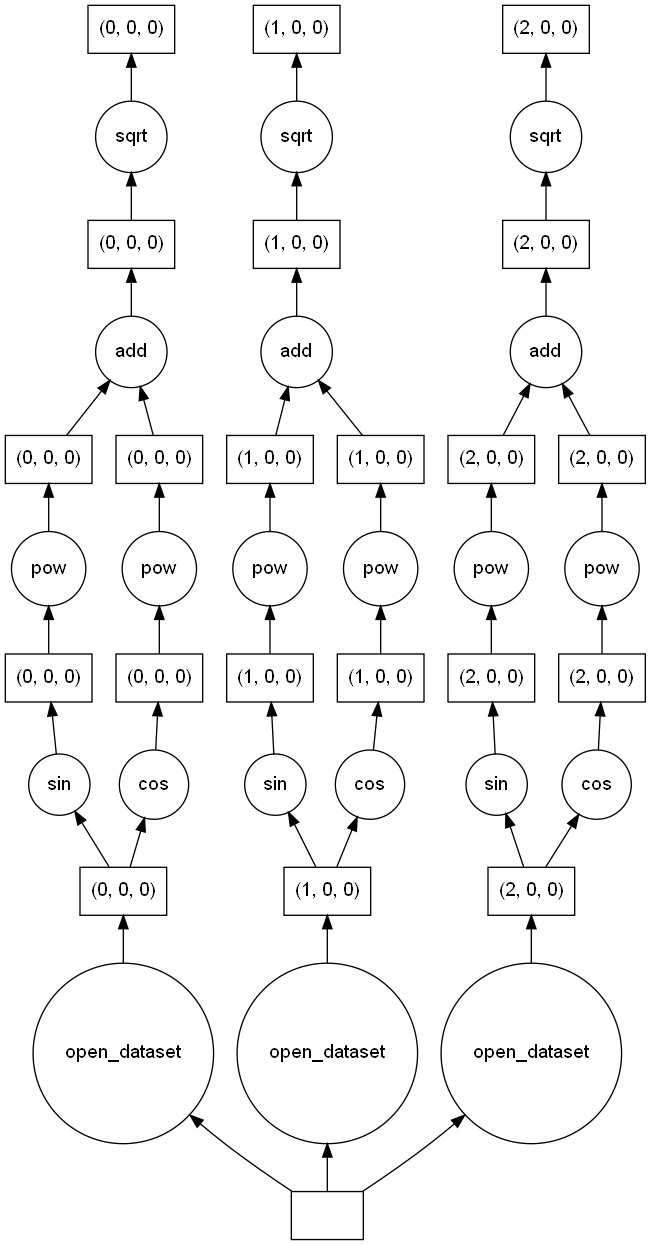

In [6]:
result = np.sqrt(np.sin(ds)**2 + np.cos(ds)**2)
result.Tair.data.visualize ()

#### A functions to split the dataset

In [7]:
import  itertools
def split_dataset (dataset):
    
    chunk_slices = {}
    for dim, chunks in dataset.chunks.items():
        slices = []
        start  = 0
    
        for chunk in chunks:
            if start >= dataset.sizes [dim]:
                break
            end = start + chunk
            slices.append (slice (start,end))
            start = end
        chunk_slices [dim] = slices 
    for slices in itertools.product (*chunk_slices.values()):
        selection = dict (zip (chunk_slices.keys(), slices))
        yield dataset[selection]
    

#### Call the function to split the dataset

In [8]:
splitted_data = list (split_dataset(result))
print ("Total split(s):", len (splitted_data))

Total split(s): 3


#### Following function generates path for each chunk

In [9]:
def create_filepath (splitted_data, prefix, directory):
    
    start = splitted_data.time.data[0].strftime ("%Y-%m-%d")
    end   = splitted_data.time.data[-1].strftime ("%Y-%m-%d")
    filepath = f'{directory}/{prefix}_{start}_{end}.nc'
    
    return filepath

#### Now generate file names

In [10]:
from pathlib import Path
from  pprint import pprint

download_path = str(Path.home() / "Downloads")

file_paths = [create_filepath (split, "split_data", download_path ) for split in splitted_data  ]
pprint(file_paths)

['C:\\Users\\Maruf2021\\Downloads/split_data_1980-09-16_1981-08-17.nc',
 'C:\\Users\\Maruf2021\\Downloads/split_data_1981-09-16_1982-08-17.nc',
 'C:\\Users\\Maruf2021\\Downloads/split_data_1982-09-16_1983-08-17.nc']


#### Use xr.save_mfdataset() to safe the list of datasets

In [11]:
xr.save_mfdataset(datasets=splitted_data, paths=file_paths)

#### Check the output

Now read the the splitted files from the disk, combine, and compare with the original dataset

In [12]:
read_dataset = xr.open_mfdataset(file_paths, combine='by_coords')
read_dataset

<xarray.Dataset>
Dimensions:  (time: 36, y: 205, x: 275)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
    yc       (y, x) float64 dask.array<chunksize=(205, 275), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    Tair     (time, y, x) float64 dask.array<chunksize=(12, 205, 275), meta=np.ndarray>

In [13]:
# Compare the datasets

try:
    xr.testing.assert_identical(result, read_dataset)
    
except AssertionError:    
    print('Two datasets are not the same')
else:
    print('Two datasets are identical')


Two datasets are identical


#### showdown and cleanup

In [15]:
result.close()
read_dataset.close()
client.close()